In [115]:
import pandas as pd
import numpy as np
import json
import os

import matplotlib.pyplot as plt
import matplotlib

matplotlib.style.use('ggplot')

pd.set_option("display.min_rows", 100)
pd.set_option("display.max_rows", 100)

In [117]:
#FILEPATH = '/Users/klogg/dev/wiki-ltt-mturk-validation/Batch_4216878_batch_results.csv'
BASEDIR = '/Users/klogg/research_data/wmf_knowledge_graph/mturk/v1/results/'

mturk_df = pd.DataFrame()
for filename in os.listdir(BASEDIR):
    filepath = os.path.join(BASEDIR,filename)
    mturk_df = mturk_df.append(pd.read_csv(filepath))

#mturk_df = pd.read_csv(FILEPATH)

In [118]:
TASKS_PER_JOB = 10
ARTICLES_PER_TASK = 5

chunk = []

for i, job_row in mturk_df.iterrows():
    answer_dict = json.loads(job_row['Answer.taskAnswers'])[0]
    imposter_map = json.loads(answer_dict['imposter_map'])
    task_list = answer_dict['task_list'].split(',')
    for i in range(0,TASKS_PER_JOB):
        key = 'articleList{0}'.format(i)
        for answer in answer_dict[key]:
            if answer_dict[key][answer]:
                response = answer.split('_',1)[1]
                response_index = answer.split('_',1)[0]
            if int(answer.split('_',1)[0]) == ARTICLES_PER_TASK:
                correct = answer_dict[key][answer]
                match = (imposter_map[str(task_list[i])] == answer.split('_',1)[1])
        task_row = {
            'correct':correct,
            'task':int(task_list[i]),
            'task_batch':answer_dict['task_batch'],
            'response':response,
            'response_index':response_index,
            'imposter':imposter_map[str(task_list[i])],
            'match':match,
            'attention_check_pass':answer_dict['attnCheck'][str(5)],
            'HIT_ID':job_row['HITId'],
            'worker_ID':job_row['WorkerId']
        }
        chunk.append(task_row)
        
results_df = pd.DataFrame(chunk)

tasks_df = pd.read_csv('/Users/klogg/research_data/wmf_knowledge_graph/mturk/tasks_10-29-20.csv')
tasks_df = tasks_df.loc[tasks_df['imposter'] == False]
tasks_df['cluster_size'] = tasks_df.groupby('cluster')['cluster'].transform(np.size)
results_df = results_df.merge(tasks_df[['cluster','task','label','cluster_size']].drop_duplicates(),on='task')

In [128]:
def rowKappa(row):
    coders = np.sum(row)
    kappa = (1/(coders*(coders-1)))*(np.sum(np.square(row))-coders)
    return kappa

num_mismatch = len(results_df.loc[results_df['match'] == False])
attention_failed = results_df.loc[results_df['attention_check_pass'] == False]['worker_ID'].nunique()
attention_failed_percent = attention_failed/len(mturk_df)
accuracy = len(results_df.loc[results_df['correct'] == True])/len(results_df)

attn_pass_results_df = results_df.loc[results_df['attention_check_pass'] == True]
irr = attn_pass_results_df.groupby(['task','response_index'])['response_index'].size().unstack().fillna(0).apply(rowKappa, raw=True,axis=1).to_frame('irr').reset_index()
attn_pass_results_df = attn_pass_results_df.merge(irr, on='task')

attn_pass_accuracy = len(attn_pass_results_df.loc[(attn_pass_results_df['correct'] == True)])/len(attn_pass_results_df.loc[attn_pass_results_df['attention_check_pass'] == True])

print('number of mismatches (should be 0): {0}'.format(num_mismatch))
print('attention checks failed: {0}'.format(attention_failed))
print('percent attention checks failed: {0}'.format(attention_failed_percent))
print('accuracy: {0}'.format(accuracy))
print('accuracy (passed attention check): {0}'.format(attn_pass_accuracy))

attn_fail_results_df = results_df.loc[results_df['attention_check_pass'] == False]
attn_fail_accuracy = len(attn_fail_results_df.loc[(attn_fail_results_df['correct'] == True)])/len(attn_fail_results_df)

print('accuracy (failed attention check): {0}'.format(attn_fail_accuracy))

agreement_df = attn_pass_results_df.groupby('task')['correct'].mean().to_frame('agree')
agreement_accuracy = len(agreement_df.loc[agreement_df['agree'] > .5])/len(agreement_df)

print('accuracy (two coders agree = correct): {0}'.format(agreement_accuracy))

number of mismatches (should be 0): 0
attention checks failed: 32
percent attention checks failed: 0.38095238095238093
accuracy: 0.4738095238095238
accuracy (passed attention check): 0.6230769230769231
accuracy (failed attention check): 0.23125
accuracy (two coders agree = correct): 0.5038461538461538


/Users/klogg/dev/knowledge_graph/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/klogg/dev/knowledge_graph/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


In [49]:
attn_fail_results_df.groupby(['HIT_ID','worker_ID'])['correct'].mean()

HIT_ID                          worker_ID     
301KG0KXAIMFLJEC49AKJ7TUSBZ2HQ  A16S2TL75YHZ79    0.1
                                A1O5EGVKYOSFBA    0.2
30UZJB2PPNDSQ8Q077NGDKVWTG853N  A3NYIJYBHAJ74V    0.0
                                AQL7N3YPKDWGW     0.1
329E6HTMT23V8RB3EURMF9EEQ63K3N  A1BQ23IXXOJRRL    0.3
34F34TZU820BCP92S9D5VK995332JV  A3AHQB31UANS2Q    0.2
3909MD9T35IN23ZM23HLINQ69ZCFE7  A1U3TT3VMH9FU9    0.9
39KMGHJ4S5BXE952REZLUR1Y9WD002  A27WORQ1PKT4G6    0.3
3A520CCNXT1S6CIERNVT4MFFCJZAEP  A2UI9967G3KJ6U    0.0
3BDORL6HLQE58VKHX7BK9O4MRBACR6  AQKSJRY788NXX     0.5
3D06DR523BKQI0AR8LJCHUKOLLQAME  A1LL4WHOQTM6JA    0.2
3DFYDSXB321KW1I4BTNB1341OUNJUV  A1IQKZL8J4FOEV    0.1
3GS542CVK1OE5AFGOGOQ4XYIT8I594  A28XB7W1YZ2NFC    0.2
                                A2OJ2KZ5NCGRIF    0.3
                                AD20ZSEI47B13     0.1
3HXK2V1N5QG1LNJ1K3S2Y7HTDBM2GR  A5OT4KL6H0A9L     0.2
3JYPJ2TAZO9RZUOCBHXWCZPAN6EFPS  A30DCRBVR9BAN7    0.1
                                A32

In [50]:
results_df.groupby('HIT_ID')['correct'].mean()

HIT_ID
301KG0KXAIMFLJEC49AKJ7TUSBZ2HQ    0.200000
30UZJB2PPNDSQ8Q077NGDKVWTG853N    0.066667
329E6HTMT23V8RB3EURMF9EEQ63K3N    0.433333
34F34TZU820BCP92S9D5VK995332JV    0.600000
37OPIVELV044QM9GHO3ZPPCS4ZRAH5    0.433333
3909MD9T35IN23ZM23HLINQ69ZCFE7    0.833333
39KMGHJ4S5BXE952REZLUR1Y9WD002    0.600000
3A520CCNXT1S6CIERNVT4MFFCJZAEP    0.400000
3BDORL6HLQE58VKHX7BK9O4MRBACR6    0.566667
3D06DR523BKQI0AR8LJCHUKOLLQAME    0.666667
3DFYDSXB321KW1I4BTNB1341OUNJUV    0.466667
3GS542CVK1OE5AFGOGOQ4XYIT8I594    0.200000
3GVPRXWRQNVM3FM2G390FABH340I7F    0.633333
3HXK2V1N5QG1LNJ1K3S2Y7HTDBM2GR    0.366667
3IKMEYR0M2W6N9FKAUDHWZ9MKS32KU    0.733333
3IKMEYR0M2W6N9FKAUDHWZ9MKS3K2C    0.700000
3JYPJ2TAZO9RZUOCBHXWCZPAN6EFPS    0.366667
3NFWQRSHWKFLMHVD8Y79IQBIMFRFGO    0.333333
3NSCTNUR35OSATPLGM2Q0S92ZQ05AJ    0.800000
3NZ1E5QA752XT3UDM02MV3T8H8L5BE    0.366667
3OKP4QVBQ8YQQQE5XILH4P0RPZEAG6    0.700000
3PCPFX4U56RCZ6PRBUCLC4FKS20FQJ    0.233333
3PN6H8C9SARNE64EVSK9Y4XUC7YADW    0.566667
3R16

In [135]:
attn_pass_by_cluster_results_df = attn_pass_results_df.groupby(['cluster','label','cluster_size'])['correct'].mean().sort_values().to_frame('accuracy')
attn_pass_by_cluster_results_df = attn_pass_by_cluster_results_df.merge(attn_pass_results_df.groupby(['cluster','label']).size().to_frame('coders'),right_index=True,left_index=True)
attn_pass_by_cluster_results_df = attn_pass_by_cluster_results_df.merge(attn_pass_results_df.dropna(axis=0,subset=['irr']).groupby('cluster')['irr'].mean().to_frame('irr'),right_index=True,left_index=True,how='left')
attn_pass_by_cluster_results_df

,,,accuracy,coders,irr
cluster,label,cluster_size,,,
506,greek ionic pamphylian night,10,0.000000,1,NaN
523,history islamic medieval world,65,0.000000,2,0.000000
1177,system electrical intelligence acm,30,0.000000,2,1.000000
1214,university research institute list,75,0.000000,1,NaN
731,procedure safety operation manual,15,0.000000,1,NaN
777,development anthropology tie chain,10,0.000000,2,1.000000
254,force wind power vehicle,45,0.000000,3,0.333333
832,list society landauer sociological,15,0.000000,2,1.000000
237,record music album winter,45,0.000000,5,0.500000


In [136]:
attn_pass_by_cluster_results_df.reset_index()[['accuracy','coders','cluster_size','irr']].corr()

,accuracy,coders,cluster_size,irr
accuracy,1.000000,0.143987,0.243773,0.516727
coders,0.143987,1.000000,0.613484,-0.092434
cluster_size,0.243773,0.613484,1.000000,-0.021949
irr,0.516727,-0.092434,-0.021949,1.000000


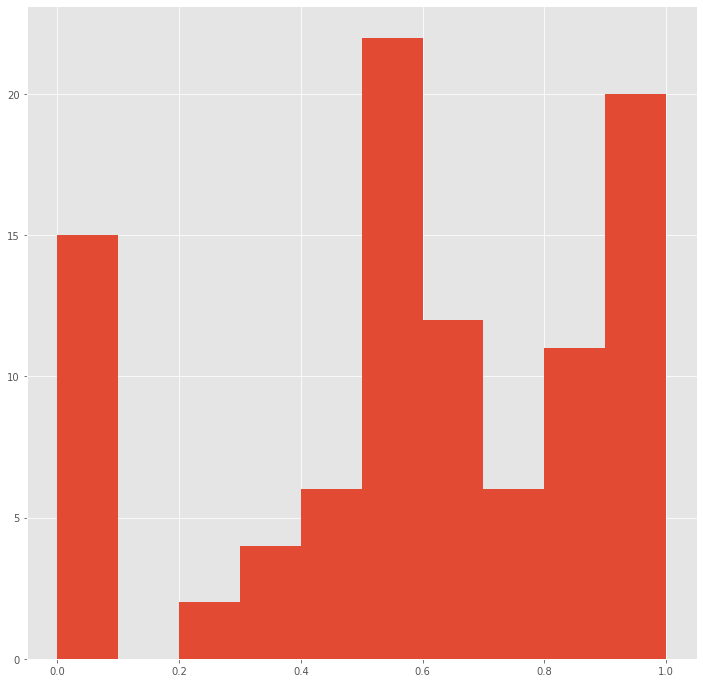

In [60]:
attn_pass_results_df.groupby(['cluster','label'])['correct'].mean().hist(bins=10,figsize=(12,12))

In [127]:
def rowKappa(row):
    coders = np.sum(row)
    kappa = (1/(coders*(coders-1)))*(np.sum(np.square(row))-coders)
    return kappa

irr = attn_pass_results_df.groupby(['task','response_index'])['response_index'].size().unstack().fillna(0).apply(rowKappa, raw=True,axis=1).to_frame('irr').reset_index()
attn_pass_results_df.merge(irr, on='task')


/Users/klogg/dev/knowledge_graph/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/klogg/dev/knowledge_graph/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


,correct,task,task_batch,response,response_index,imposter,match,attention_check_pass,HIT_ID,worker_ID,cluster,label,cluster_size,irr
114,True,4,409,Systems_theory_in_anthropology,5,Systems_theory_in_anthropology,True,True,3OKP4QVBQ8YQQQE5XILH4P0RPZEAG6,A1IFIK8J49WBER,4,sutra buddhist buddhism list,55,1.000000
115,True,4,409,Systems_theory_in_anthropology,5,Systems_theory_in_anthropology,True,True,3OKP4QVBQ8YQQQE5XILH4P0RPZEAG6,A2NUGRVI6IEGN7,4,sutra buddhist buddhism list,55,1.000000
490,False,7,49,Amitābha,0,Stephen_Blair_Hedges,True,True,3NZ1E5QA752XT3UDM02MV3T8H8L5BE,AJ9356RKKZTY4,4,sutra buddhist buddhism list,55,NaN
178,True,20,699,Religious_skepticism,5,Religious_skepticism,True,True,3GVPRXWRQNVM3FM2G390FABH340I7F,A88RBIQEK5OFT,28,matthew luke john mark,90,1.000000
176,True,20,699,Religious_skepticism,5,Religious_skepticism,True,True,3GVPRXWRQNVM3FM2G390FABH340I7F,AYR6ZQ8YXMSF5,28,matthew luke john mark,90,1.000000
177,True,20,699,Religious_skepticism,5,Religious_skepticism,True,True,3GVPRXWRQNVM3FM2G390FABH340I7F,A2E0LU8V4EUX5C,28,matthew luke john mark,90,1.000000
69,True,22,1379,Shellfish_poisoning,5,Shellfish_poisoning,True,True,3S1L4CQSG36KCQIAMYFZM40FOKEAF7,A2YIB84VKYNKWD,28,matthew luke john mark,90,1.000000
68,True,22,1379,Shellfish_poisoning,5,Shellfish_poisoning,True,True,3S1L4CQSG36KCQIAMYFZM40FOKEAF7,A3U36WJYNYSNES,28,matthew luke john mark,90,1.000000
266,True,25,559,Huns,5,Huns,True,True,3JYPJ2TAZO9RZUOCBHXWCZPAN6EFPS,A2DVV59R1CQU6T,28,matthew luke john mark,90,NaN
496,False,34,49,John_13,2,New_Years_Day,True,True,3NZ1E5QA752XT3UDM02MV3T8H8L5BE,AJ9356RKKZTY4,28,matthew luke john mark,90,NaN


In [101]:
fleiss_kappa([[0,0,0,2],[1,1,1,0]])

AssertionError: 

In [132]:
attn_pass_results_df.dropna(axis=0,subset=['irr']).groupby('cluster')['irr'].mean()

cluster
4       1.000000
28      1.000000
53      0.000000
65      0.400000
69      0.166667
72      0.333333
95      0.250000
107     0.000000
112     0.000000
132     0.000000
170     0.666667
176     0.000000
178     0.222222
214     0.333333
217     0.400000
236     0.454545
237     0.500000
244     0.222222
254     0.333333
258     0.285714
276     0.333333
293     1.000000
303     1.000000
308     1.000000
331     0.166667
374     1.000000
380     0.500000
422     0.000000
423     1.000000
428     0.500000
445     1.000000
451     1.000000
453     1.000000
458     0.333333
459     1.000000
464     0.600000
512     1.000000
523     0.000000
577     0.222222
608     0.250000
624     1.000000
633     1.000000
657     0.000000
659     1.000000
666     1.000000
678     0.400000
680     0.750000
704     1.000000
706     0.500000
728     0.000000
746     1.000000
777     1.000000
789     0.333333
807     0.500000
814     0.600000
832     1.000000
850     0.000000
855     0.000000
860   